In [2]:
from typing import Callable

import numpy as np
from numpy import ndarray

import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm

from scipy.optimize import rosen, rosen_der

# Nelder--Mead: derivative-free optimisation of functions of many variables

In this notebook we test the Nelder--Mead method with the Rosenbrock function, a classic test of optimisation methods.

The Rosenbrock function (a.k.a. the Valley or Banana function) has a single minimum in a narrow, banana-shaped valley.
\begin{equation}
f{\left(\mathbf{x}\right)} = \sum_{i=0}^{d-1} \left[100\left(x_{i+1}-x_{i}^{2}\right)^{2} + \left(x_{i}-1\right)^{2} \right]
\end{equation}
We will consider the 2D case, $d=2$.

/var/folders/26/33gfkypd2f930_67mdqmxs8m0000gn/T/ipykernel_74888/3518456040.py:40: UserWarning: FixedFormatter should only be used together with FixedLocator
  axins.set_xticklabels(
/var/folders/26/33gfkypd2f930_67mdqmxs8m0000gn/T/ipykernel_74888/3518456040.py:43: UserWarning: FixedFormatter should only be used together with FixedLocator
  axins.set_yticklabels(


Text(0.5, 1.0, 'The 2D Rosenbrock function.')

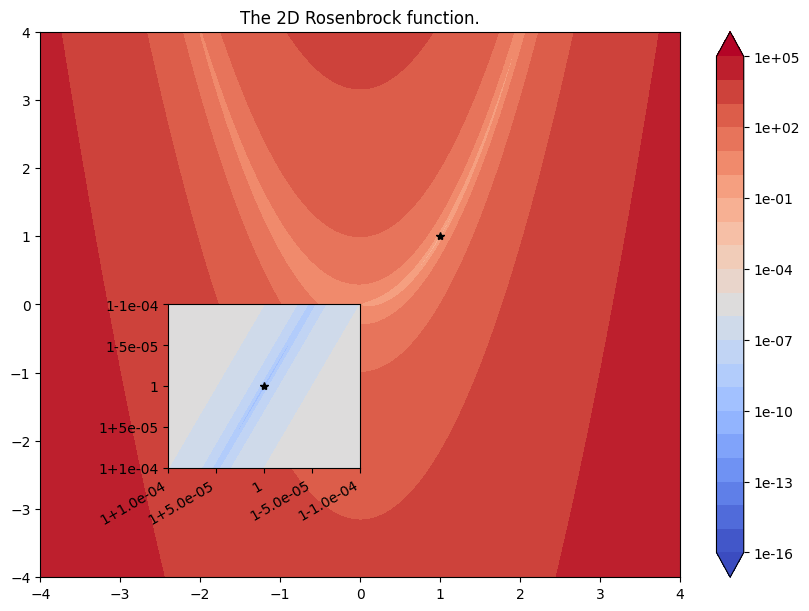

In [3]:
fig, ax = plt.subplots(1, 1, constrained_layout=True, figsize=(8, 6))

xs = np.linspace(-4, 4, 402)
ys = np.linspace(-4, 4, 402)
xs, ys = np.meshgrid(xs, ys)
points = np.stack([xs, ys])

ax.plot([1], [1], 'k*')
cs = ax.contourf(
    xs, ys, rosen(points),
    cmap=plt.get_cmap("coolwarm"),
    levels=np.geomspace(1e-16, 1e5, 22),
    norm=LogNorm(),
    extend='both',
)
cbar = fig.colorbar(cs)
cbar.ax.set_yticklabels([f'{tick:.0e}' for tick in np.geomspace(1e-16, 1e5, 22)])

ax.set_xlim(-4, 4)
ax.set_ylim(-4, 4)


axins = ax.inset_axes([0.2, 0.2, 0.3, 0.3], transform=ax.transAxes)

xs = np.linspace(1 - 1e-4, 1 + 1e-4, 402)
ys = np.linspace(1 - 1e-4, 1 + 1e-4, 402)
xs, ys = np.meshgrid(xs, ys)
points = np.stack([xs, ys])


cs = axins.contourf(
    xs, ys, rosen(points),
    cmap=plt.get_cmap("coolwarm"),
    levels=np.geomspace(1e-16, 1e5, 22),
    norm=LogNorm(),
    extend='both',
)

axins.plot([1],[1],'k*')
axins.set_xticklabels(
    [f'1{(1-x):+.1e}' if x!=1 else '1' for x in axins.get_xticks()], rotation=30, ha='right'
)
axins.set_yticklabels(
    [f'1{(1-x):+.0e}' if x!=1 else '1' for x in axins.get_yticks()]
)


ax.set_title(f"The 2D Rosenbrock function.")

The logic of the Nelder--Mead method is very simple:
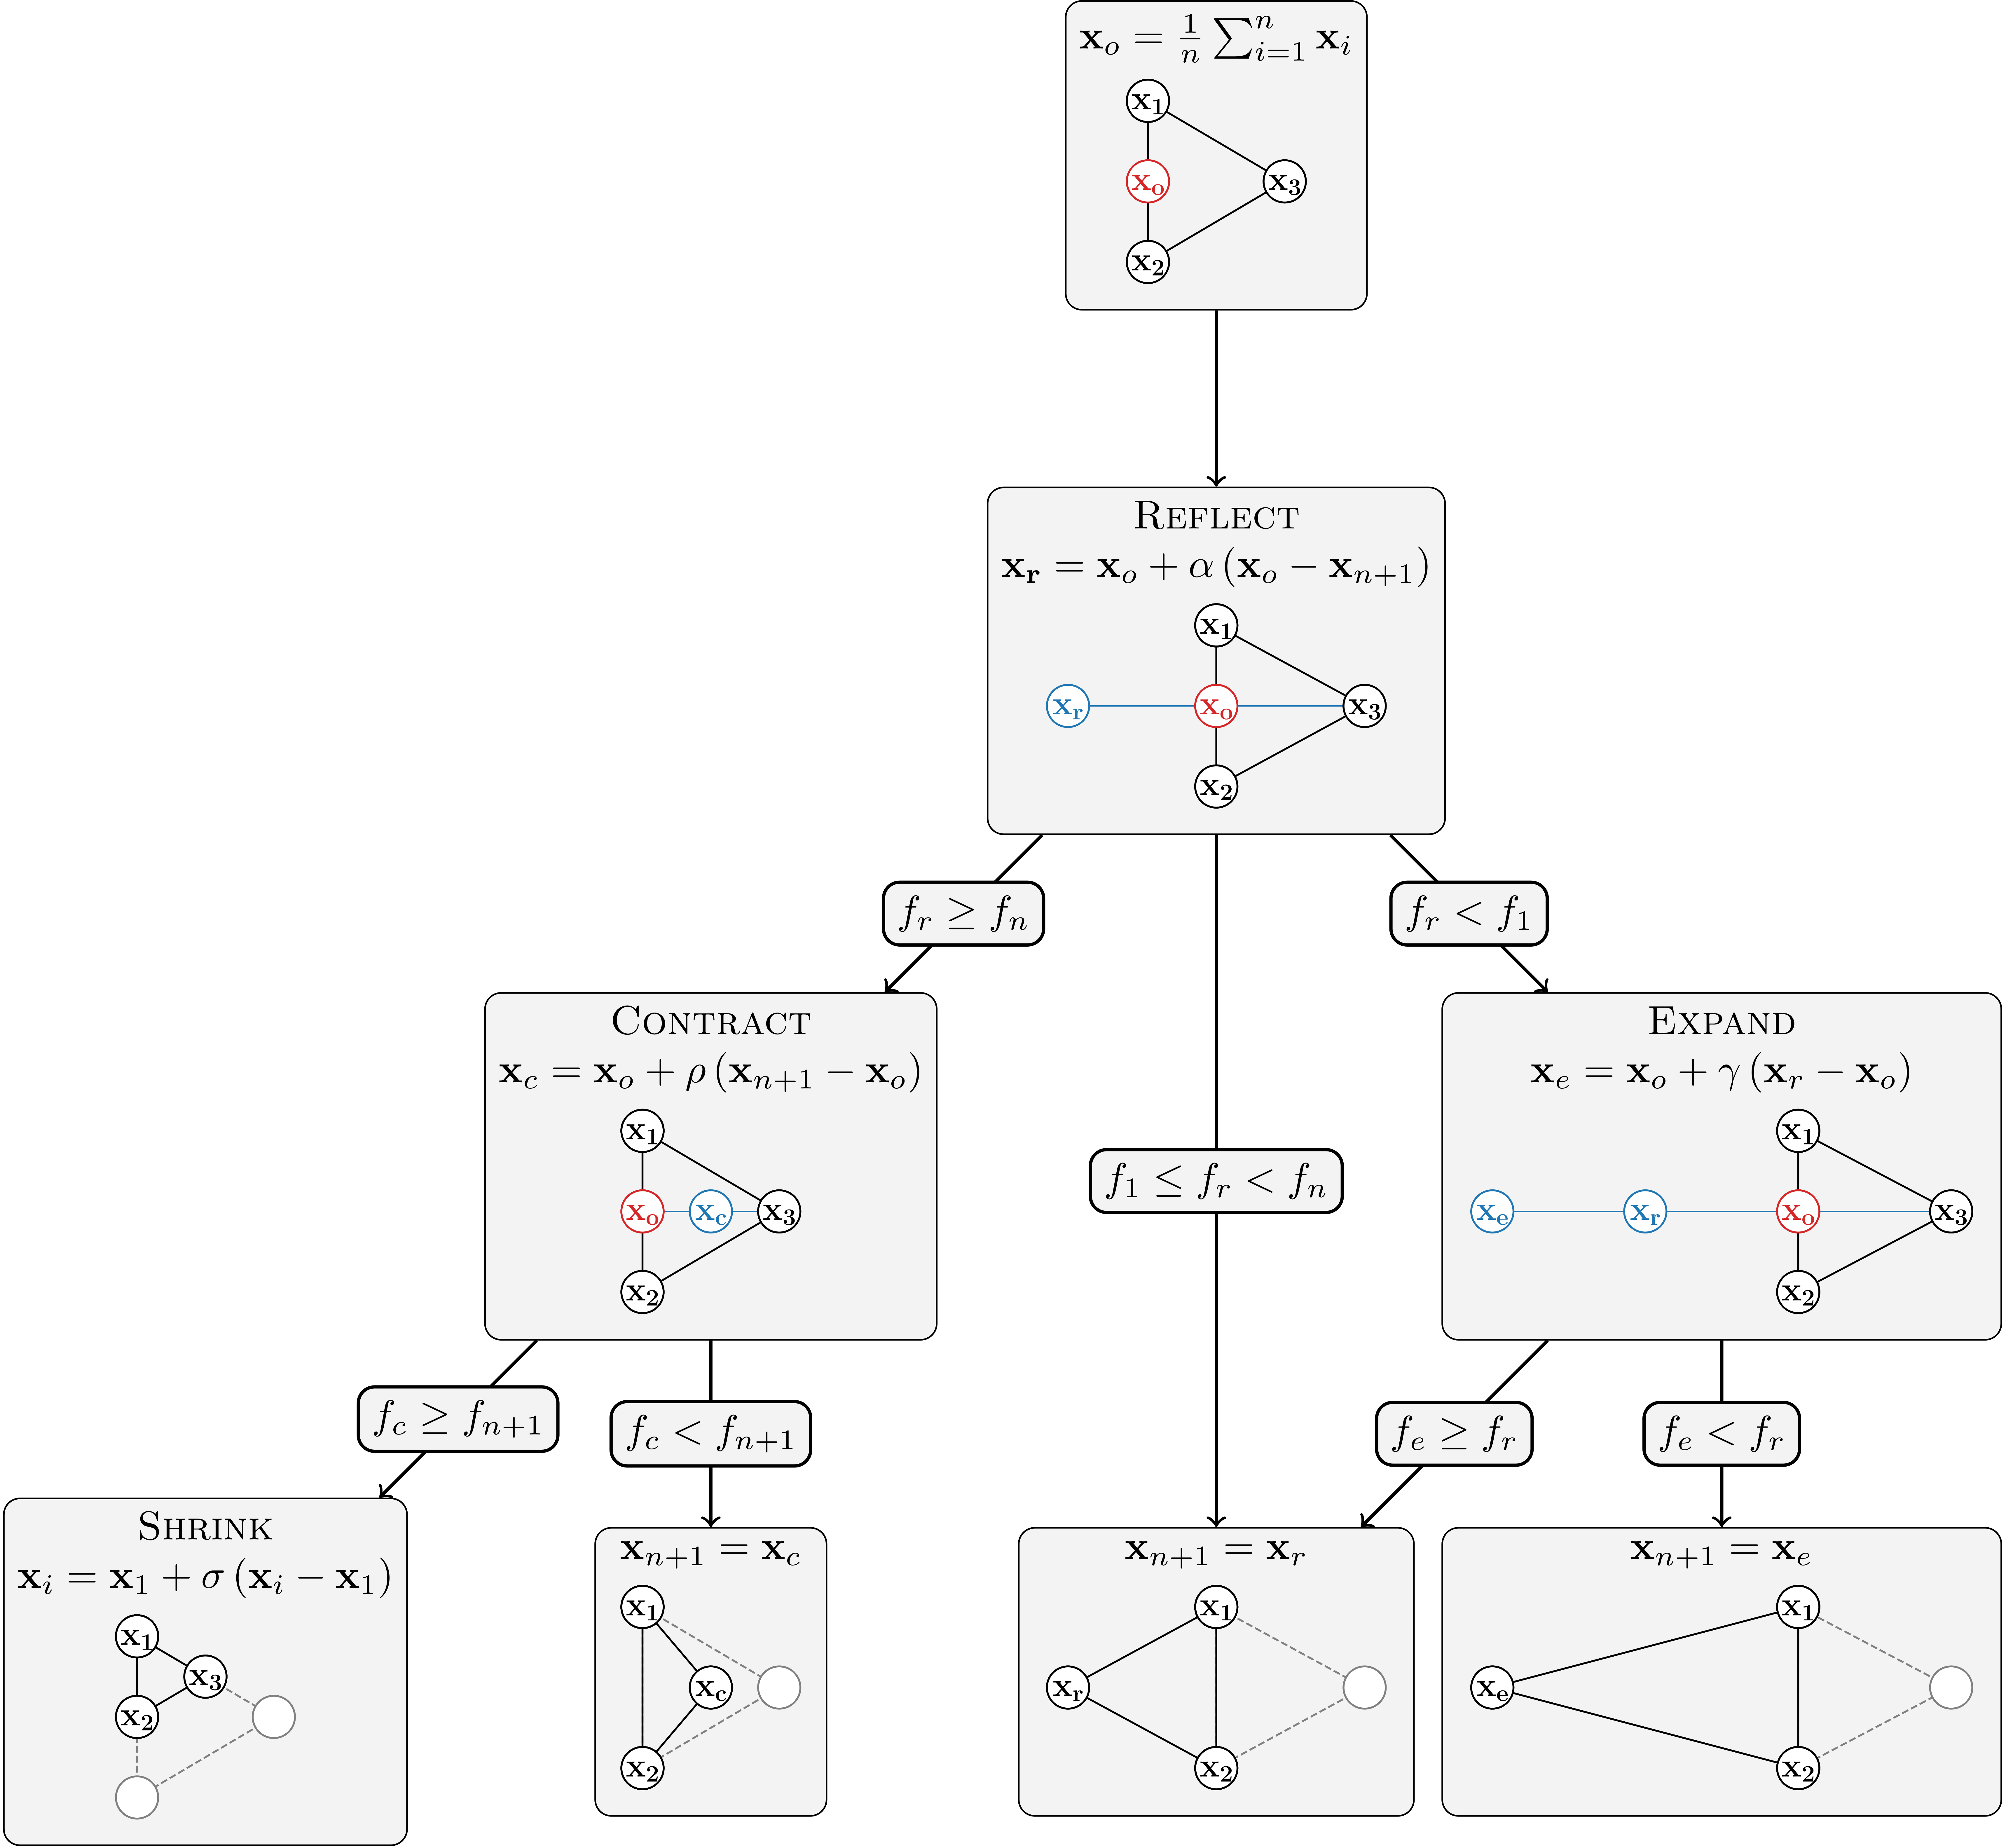

In [54]:
def nelder_mead(
    f: Callable[[ndarray], ndarray],
    xs: [[float]],
    tol: 1e-4,
    alpha: float = 1.0,
    gamma: float = 2.0, 
    rho: float = 0.5,
    sigma: float = 0.5,
) -> ndarray:
    
    sequence = []
    
    while max(np.std(np.array(xs)[:, 0]),np.std(np.array(xs)[:, 1]))>tol:
        
        xs = sorted(xs, key=lambda x: f(x))
        xo=np.mean(xs[:-1], axis=0)
        sequence.append(xs)
        xr=xo+alpha*(xo-xs[-1])
        
        if f(xr)>=f(xs[-2]):
            xc=xo+rho*(xs[-1]-xo)
            
            if f(xc)>=f(xs[-1]):
                for i in range(len(xs)):
                    xs[i]=xs[0]+sigma*(xs[i]-xs[0])
            else:
                xs[-1]=xc
        elif f(xr)>=f(xs[0]):
            xs[-1]=xr
        else:
            xe=xo+gamma*(xr-xo)
            
            if f(xe)>=f(xr):
                xs[-1]=xr
            else:
                xs[-1]=xe
            
    return sequence


In [58]:
simplex = np.array(
    [
        [0.0, 0.0],
        [2.0, 0.0],
        [0.0, 3.0]
    ]
)

sequence = nelder_mead(f=rosen, xs=simplex, tol=1e-6)

fig, ax = plt.subplots(1, 1, constrained_layout=True, figsize=(8,6))


for frame, simplex in enumerate(sequence):
    simplex = np.array(simplex)
    if frame % 1 and frame > 10 and frame != len(sequence) - 1:
        continue
    print(f"drawing frame {frame}")

    simplexx = np.array([*simplex[:,0], simplex[0, 0]])
    simplexy = np.array([*simplex[:,1], simplex[0, 1]])
    ax.plot(simplexx, simplexy, 'ko--')

    if frame == 0:
        xlim, ylim = [[-4, 4], [-4, 4]]
    else:
        xlim = np.array([min(simplexx.min(), 1), max(simplexx.max(), 1)])
        xlim[0] -= (xlim[1]-xlim[0])*0.1
        xlim[1] += (xlim[1]-xlim[0])*0.1
        ylim = np.array([min(simplexy.min(), 1), max(simplexy.max(), 1)])
        ylim[0] -= (ylim[1]-ylim[0])*0.1
        ylim[1] += (ylim[1]-ylim[0])*0.1

    xs = np.linspace(*xlim, 402)
    ys = np.linspace(*ylim, 402)
    xs, ys = np.meshgrid(xs, ys)
    points = np.stack([xs, ys])

    ax.plot([1],[1],'k*')
    cs = ax.contourf(
        xs, ys, rosen(points),
        cmap=plt.get_cmap("coolwarm"),
        levels=np.geomspace(1e-16,1e5,22),
        norm=LogNorm(),
        extend='both',
    )
    cbar = fig.colorbar(cs)
    cbar.ax.set_yticklabels([f'{tick:.0e}' for tick in np.geomspace(1e-16,1e5,22)])
    
    ax.set_xlim(*xlim)
    ax.set_ylim(*ylim)
    
    ax.set_title(f"iteration {frame}; mean $\sigma={np.mean(np.std(simplex, axis=0)):.1g}$")
    plt.savefig(f"neldermead.{frame:03n}.png", dpi=160)
    
    ax.cla()
    cbar.remove()
fig.clf()

drawing frame 0
drawing frame 1
drawing frame 2
drawing frame 3
drawing frame 4
drawing frame 5
drawing frame 6
drawing frame 7
drawing frame 8
drawing frame 9
drawing frame 10
drawing frame 11
drawing frame 12
drawing frame 13
drawing frame 14
drawing frame 15
drawing frame 16
drawing frame 17
drawing frame 18
drawing frame 19
drawing frame 20
drawing frame 21
drawing frame 22
drawing frame 23
drawing frame 24
drawing frame 25
drawing frame 26
drawing frame 27
drawing frame 28
drawing frame 29
drawing frame 30
drawing frame 31
drawing frame 32
drawing frame 33
drawing frame 34
drawing frame 35
drawing frame 36
drawing frame 37
drawing frame 38
drawing frame 39
drawing frame 40
drawing frame 41
drawing frame 42
drawing frame 43
drawing frame 44
drawing frame 45
drawing frame 46
drawing frame 47
drawing frame 48
drawing frame 49
drawing frame 50
drawing frame 51
drawing frame 52
drawing frame 53
drawing frame 54
drawing frame 55
drawing frame 56
drawing frame 57
drawing frame 58
drawing

<Figure size 800x600 with 0 Axes>

In [84]:
simplex1=np.array([[0,0,0],[1,0,0],[0,1,0],[0,0,1]])
path=nelder_mead(f=rosen, xs=simplex1, tol=1e-9)
print("{:.8f}".format(rosen(path[0][0])))
print("{:.8f}".format(rosen(path[20][0])))
print("{:.8f}".format(rosen(path[40][0])))
print("{:.8f}".format(rosen(path[60][0])))
print("{:.8f}".format(rosen(path[80][0])))
print("{:.8f}".format(rosen(path[100][0])))
print("{:.8f}".format(rosen(path[120][0])))
print("{:.8f}".format(rosen(path[140][0])))
print("{:.8f}".format(rosen(path[160][0])))

2.00000000
2.00000000
1.05283798
0.32804053
0.05063484
0.00146495
0.00004469
0.00000022
0.00000000
